In [142]:
import matplotlib.pyplot as plt
import torch as tc
from torchdiffeq import odeint as odeint

from torch import nn
from models import SIR
from tqdm import tqdm

In [201]:
tmin = 0
tmax = 200 #days
dt = 1. #hourly

N = 10**6
I0 = 1
R0 = 0
S0 = N - I0 - R0

In [190]:
sir_true = SIR(beta=0.2, gamma=0.1, N=N, S0=S0, I0 = I0, R0 = R0, tmin=tmin, tmax=tmax, dt = dt)

In [204]:
with tc.no_grad():
    S, I, R, _ = odeint(sir_true, sir_true.init_conditions, sir_true.t).T
    pred = sir_true.params[0] * S * I / N
    data = tc.distributions.Poisson(pred).sample()
    data_idx = tc.arange(tmin,int((tmax - tmin)/dt), int(1/dt))
    data = data[data_idx]   

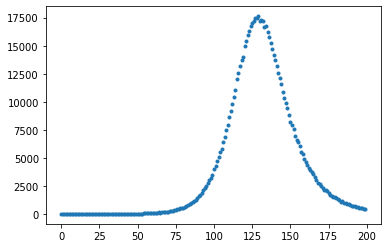

In [205]:
plt.plot(data, '.') #daily cases

In [237]:
class ODE(nn.Module):

    def __init__(self, init_params, y0):
        super(ODE, self).__init__()
        self.init_params = init_params
        self.y0 = y0
        self.beta = nn.Parameter(init_params[0])
        self.gamma = nn.Parameter(init_params[1])

    def forward(self, t, y):
        S, I, R, N = y

        dS = - self.beta * S * I / N
        dI = self.beta * S * I / N - self.gamma * I
        dR = self.beta * I
        dN = tc.tensor(0.0)

        return tc.stack([dS, dI, dR, dN])
    

In [257]:
def likelihood(func, data, S0, I0, R0, N, t):
    S, I, R, _ = odeint(func, tc.tensor([S0, I0, R0, N]).float(), t).T

    pred = func.beta * S * I / N

    return (1/N) * (pred.mean() - (1/len(t)) * tc.dot(pred.log(), data))


In [275]:
func = ODE(tc.tensor([0.5, 0.3]), tc.tensor([S0, I0, R0, N]).float())
optimizer = tc.optim.Adam(func.parameters(), lr=1e-1)
losses = []
tol = 1e-5
g = tc.tensor(1.0)
while g > tol:
    optimizer.zero_grad()
    l = likelihood(func, data, S0, I0, R0, N, sir_true.t)
    
    l.backward()
    print("Loss : {} , beta : {}, gamma : {} Grad beta : {}, Grad gamma {}".format(l, func.beta.clone().detach(), func.gamma.clone().detach(), func.beta.grad, func.gamma.grad))
    optimizer.step()
    g = tc.sqrt((func.beta.grad**2) + (func.gamma.grad)**2)
    losses.append(l.clone().detach())

Loss : -0.0030612715054303408 , beta : 0.5, gamma : 0.30000001192092896 Grad beta : 0.2771368622779846, Grad gamma -0.23698174953460693
Loss : 0.0036217595916241407 , beta : 0.4000000059604645, gamma : 0.4000000059604645 Grad beta : -0.5284892320632935, Grad gamma 0.5186551809310913
Loss : -0.02991972304880619 , beta : 0.4348030686378479, gamma : 0.3601463735103607 Grad beta : -0.19972458481788635, Grad gamma 0.19809776544570923
Loss : -0.011188189499080181 , beta : 0.48059946298599243, gamma : 0.3100729286670685 Grad beta : 0.297524631023407, Grad gamma -0.2671886682510376
Loss : -0.005015137605369091 , beta : 0.48964640498161316, gamma : 0.29611262679100037 Grad beta : 0.2799689471721649, Grad gamma -0.24156534671783447
Loss : -0.010779550299048424 , beta : 0.4763602316379547, gamma : 0.303801029920578 Grad beta : 0.2947368621826172, Grad gamma -0.26341816782951355
Loss : -0.026398271322250366 , beta : 0.4465861916542053, gamma : 0.3283531665802002 Grad beta : 0.26971957087516785, Gr

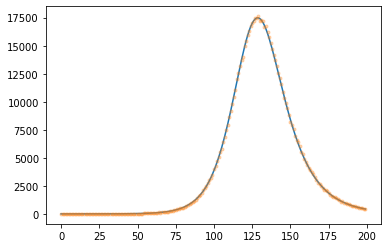

In [279]:
S, I, R, _ = odeint(func, tc.tensor([S0, I0, R0, N]).float(), sir_true.t).T
pred = func.beta * S * I / N
plt.plot(pred.detach())
plt.plot(data.clone().detach(), '.', alpha=0.3)